In [78]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from seqeval.metrics import classification_report, precision_score
from IPython.display import HTML

from model import BiLSTM_CRF
from dataset import io2df, io2bio, padding, NERDataset
from utils import Config, load_ner_config
from visualisation import plot_classification_report, highlight_entities
from typing import List, Dict

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
config = Config('config.yaml')
config.__dict__

{'TR_PATH': 'data/supervised/train.txt',
 'VA_PATH': 'data/supervised/dev.txt',
 'TE_PATH': 'data/supervised/test.txt',
 'SEQ_LEN': 64,
 'BATCH_SIZE': 128,
 'LR': 0.001,
 'REG_LAMBDA': 0.0001,
 'MAX_GRAD_NORM': 100,
 'NUM_EPOCHS': 10,
 'EMBED_SIZE': 128,
 'HIDDEN_SIZE': 128,
 'DROPOUT': 0.5}

In [3]:
te_titles = io2df(config.TE_PATH)

100%|██████████| 958765/958765 [00:01<00:00, 708832.09it/s]


In [4]:
TAG2IDX = load_ner_config('ner_tags/ner_fine_grained.json')
IDX2TAG = {i: t for t, i in TAG2IDX.items()}

TKN2IDX = load_ner_config('tokenizers/token2idx.json')
IDX2TKN = {i: t for t, i in TKN2IDX.items()}

In [5]:
# encode
te_titles['tags_ids'] = te_titles['tags_fine_grained'].transform(lambda x: [TAG2IDX[tag] for tag in x])
te_titles['tokens_ids'] = te_titles['tokens'].transform(lambda x: [TKN2IDX[token] if token in TKN2IDX else TKN2IDX['UKN'] for token in x])

# padding
te_titles['tokens_ids'] = te_titles['tokens_ids'].transform(padding, max_len=config.SEQ_LEN)
te_titles['tags_ids'] = te_titles['tags_ids'].transform(padding, max_len=config.SEQ_LEN)

In [6]:
te_titles

,id,tokens,tags_fine_grained,tags_coarse_grained,tags_ids,tokens_ids
0,0,"[In, the, early, 1930s, the, band, moved, to, ...","[O, O, O, O, O, O, O, O, O, building-other, bu...","[O, O, O, O, O, O, O, O, O, building, building...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 12, 12, 1, 1, 10, ...","[25, 2, 166, 2825, 2, 277, 246, 8, 2, 7432, 39..."
1,1,"[The, final, season, of, minor, league, play, ...","[O, O, O, O, O, O, O, location-park, location-...","[O, O, O, O, O, O, O, location, location, loca...","[1, 1, 1, 1, 1, 1, 1, 27, 27, 27, 1, 1, 1, 1, ...","[12, 288, 81, 5, 1541, 567, 267, 30529, 782, 1..."
2,2,"[They, finished, the, season, 14–19, ,, 9–9, i...","[O, O, O, O, O, O, O, O, event-sportsevent, ev...","[O, O, O, O, O, O, O, O, event, event, O, O, O...","[1, 1, 1, 1, 1, 1, 1, 1, 21, 21, 1, 1, 1, 1, 1...","[198, 528, 2, 81, 1, 3, 1, 7, 22858, 267, 8, 2..."
3,3,"[The, B-52, pilot, ,, Major, Larry, G., Messin...","[O, product-other, O, O, O, person-other, pers...","[O, product, O, O, O, person, person, person, ...","[1, 63, 1, 1, 1, 55, 55, 55, 1, 1, 1, 1, 0, 0,...","[12, 15859, 1689, 3, 1122, 3247, 3210, 1, 3, 7..."
4,4,"[The, Austro-Hungarian, Navy, built, and, oper...","[O, organization-other, organization-other, O,...","[O, organization, organization, O, O, O, O, O,...","[1, 33, 33, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0...","[12, 15069, 675, 178, 6, 445, 50, 2480, 5, 359..."
...,...,...,...,...,...,...
37643,37643,"[The, remaining, 25, were, scrapped, in, 1959, .]","[O, O, O, O, O, O, O, O]","[O, O, O, O, O, O, O, O]","[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...","[12, 1448, 453, 30, 9933, 7, 1423, 4, 0, 0, 0,..."
37644,37644,"[Lady, Forester, died, in, 1922, .]","[O, person-other, O, O, O, O]","[O, person, O, O, O, O]","[1, 55, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[2162, 1, 278, 7, 2376, 4, 0, 0, 0, 0, 0, 0, 0..."
37645,37645,"[As, all, aminopenicillins, ,, amoxicillin, ha...","[O, O, other-chemicalthing, O, other-chemicalt...","[O, O, other, O, other, O, O, O, O, other, oth...","[1, 1, 42, 1, 42, 1, 1, 1, 1, 44, 44, 1, 44, 4...","[191, 95, 1, 3, 28054, 38, 47, 818, 20, 1, 163..."
37646,37646,"[The, Storm, Prediction, Center, in, Oklahoma,...","[O, organization-other, organization-other, or...","[O, organization, organization, organization, ...","[1, 33, 33, 33, 1, 22, 1, 1, 1, 1, 1, 1, 1, 1,...","[12, 4050, 1, 222, 7, 2443, 40, 1282, 2, 4180,..."


In [7]:
te_dataset = NERDataset(te_titles)
te_dataloader = DataLoader(dataset=te_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=4)

te_dataset.__getitem__(123)

{'tokens_ids': tensor([ 3474,    48,    96,   115,   158,     3,    29,  1209,     9,  3190,
             5,   557,     7, 17140,     6,  2211,    34,     8,     2,   324,
          1231,   313,     3, 23582,     1,     3,    16,     2,   284,     5,
             9,  1597,     4,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0]),
 'tags_ids': tensor([ 1,  1, 16, 16, 16,  1,  1,  1,  1,  1,  1,  1,  1, 22,  1,  1,  1,  1,
          1,  1,  1,  1,  1, 38, 38,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0])}

In [8]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = BiLSTM_CRF(
    embed_size     = config.EMBED_SIZE,
    hidden_size    = config.HIDDEN_SIZE, 
    dropout        = config.DROPOUT,
    token_voc_size = len(TKN2IDX), 
    tag_voc_size   = len(TAG2IDX),
).to(device)

token_embedding.weight         initialized w with Xavier            parameters #: 4442240
lstm.weight_ih_l0              initialized w with Xavier            parameters #: 32768
lstm.weight_hh_l0              initialized w with Xavier            parameters #: 16384
lstm.weight_ih_l0_reverse      initialized w with Xavier            parameters #: 32768
lstm.weight_hh_l0_reverse      initialized w with Xavier            parameters #: 16384
fc.weight                      initialized w with Xavier            parameters #: 8704
fc.bias                        initialized b with zero              parameters #: 68
crf.start_transitions          initialized b with zero              parameters #: 68
crf.end_transitions            initialized b with zero              parameters #: 68
crf.transitions                initialized w with Xavier            parameters #: 4624


In [11]:
state_dict = torch.load(f='artefacts/fine_grained/weigths/model_epoch_06.pt', map_location=torch.device(device))
model.load_state_dict(state_dict=state_dict)
model.eval()

BiLSTM_CRF(
  (token_embedding): Embedding(34705, 128)
  (lstm): LSTM(128, 64, bias=False, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=68, bias=True)
  (crf): CRF(num_tags=68)
)

In [12]:
batch_trues = []
batch_preds = []

for va_batch in tqdm(te_dataloader, total=te_dataloader.__len__()):
    te_xs = va_batch['tokens_ids'].to(device)
    te_ys = va_batch['tags_ids'].to(device)

    te_emission_scores = model(te_xs).to(device)
    te_preds = torch.tensor(model.decode(te_emission_scores))

    mask = (te_ys > 0).bool()
    
    for row_id, true in enumerate(te_ys):
        # do not count padding
        true_tags = true[mask[row_id]]
        # idx2tag
        true_tags = [IDX2TAG[idx] for idx in true_tags.tolist()]
        # convert to the format expected by seqeval
        true_tags = io2bio(true_tags)
        batch_trues.append(true_tags)

    for row_id, pred in enumerate(te_preds):
        # do not count padding
        pred_tags = pred[mask[row_id]]
        # idx2tag
        pred_tags = [IDX2TAG[idx] for idx in pred_tags.tolist()]
        # convert to the format expected by seqeval
        pred_tags = io2bio(pred_tags)
        batch_preds.append(pred_tags)

report = classification_report(y_true=batch_trues, y_pred=batch_preds, zero_division=0)
print(report)

  0%|          | 0/295 [00:00<?, ?it/s]

100%|██████████| 295/295 [01:10<00:00,  4.20it/s]


                                          precision    recall  f1-score   support

                    art-broadcastprogram       0.52      0.33      0.40       597
                                art-film       0.59      0.48      0.53       752
                               art-music       0.57      0.57      0.57      1028
                               art-other       0.23      0.15      0.18       562
                            art-painting       0.24      0.09      0.13        58
                          art-writtenart       0.47      0.45      0.46      1009
                        building-airport       0.82      0.76      0.79       363
                       building-hospital       0.71      0.70      0.71       362
                          building-hotel       0.70      0.56      0.62       263
                        building-library       0.68      0.63      0.65       355
                          building-other       0.51      0.41      0.45      2534
               

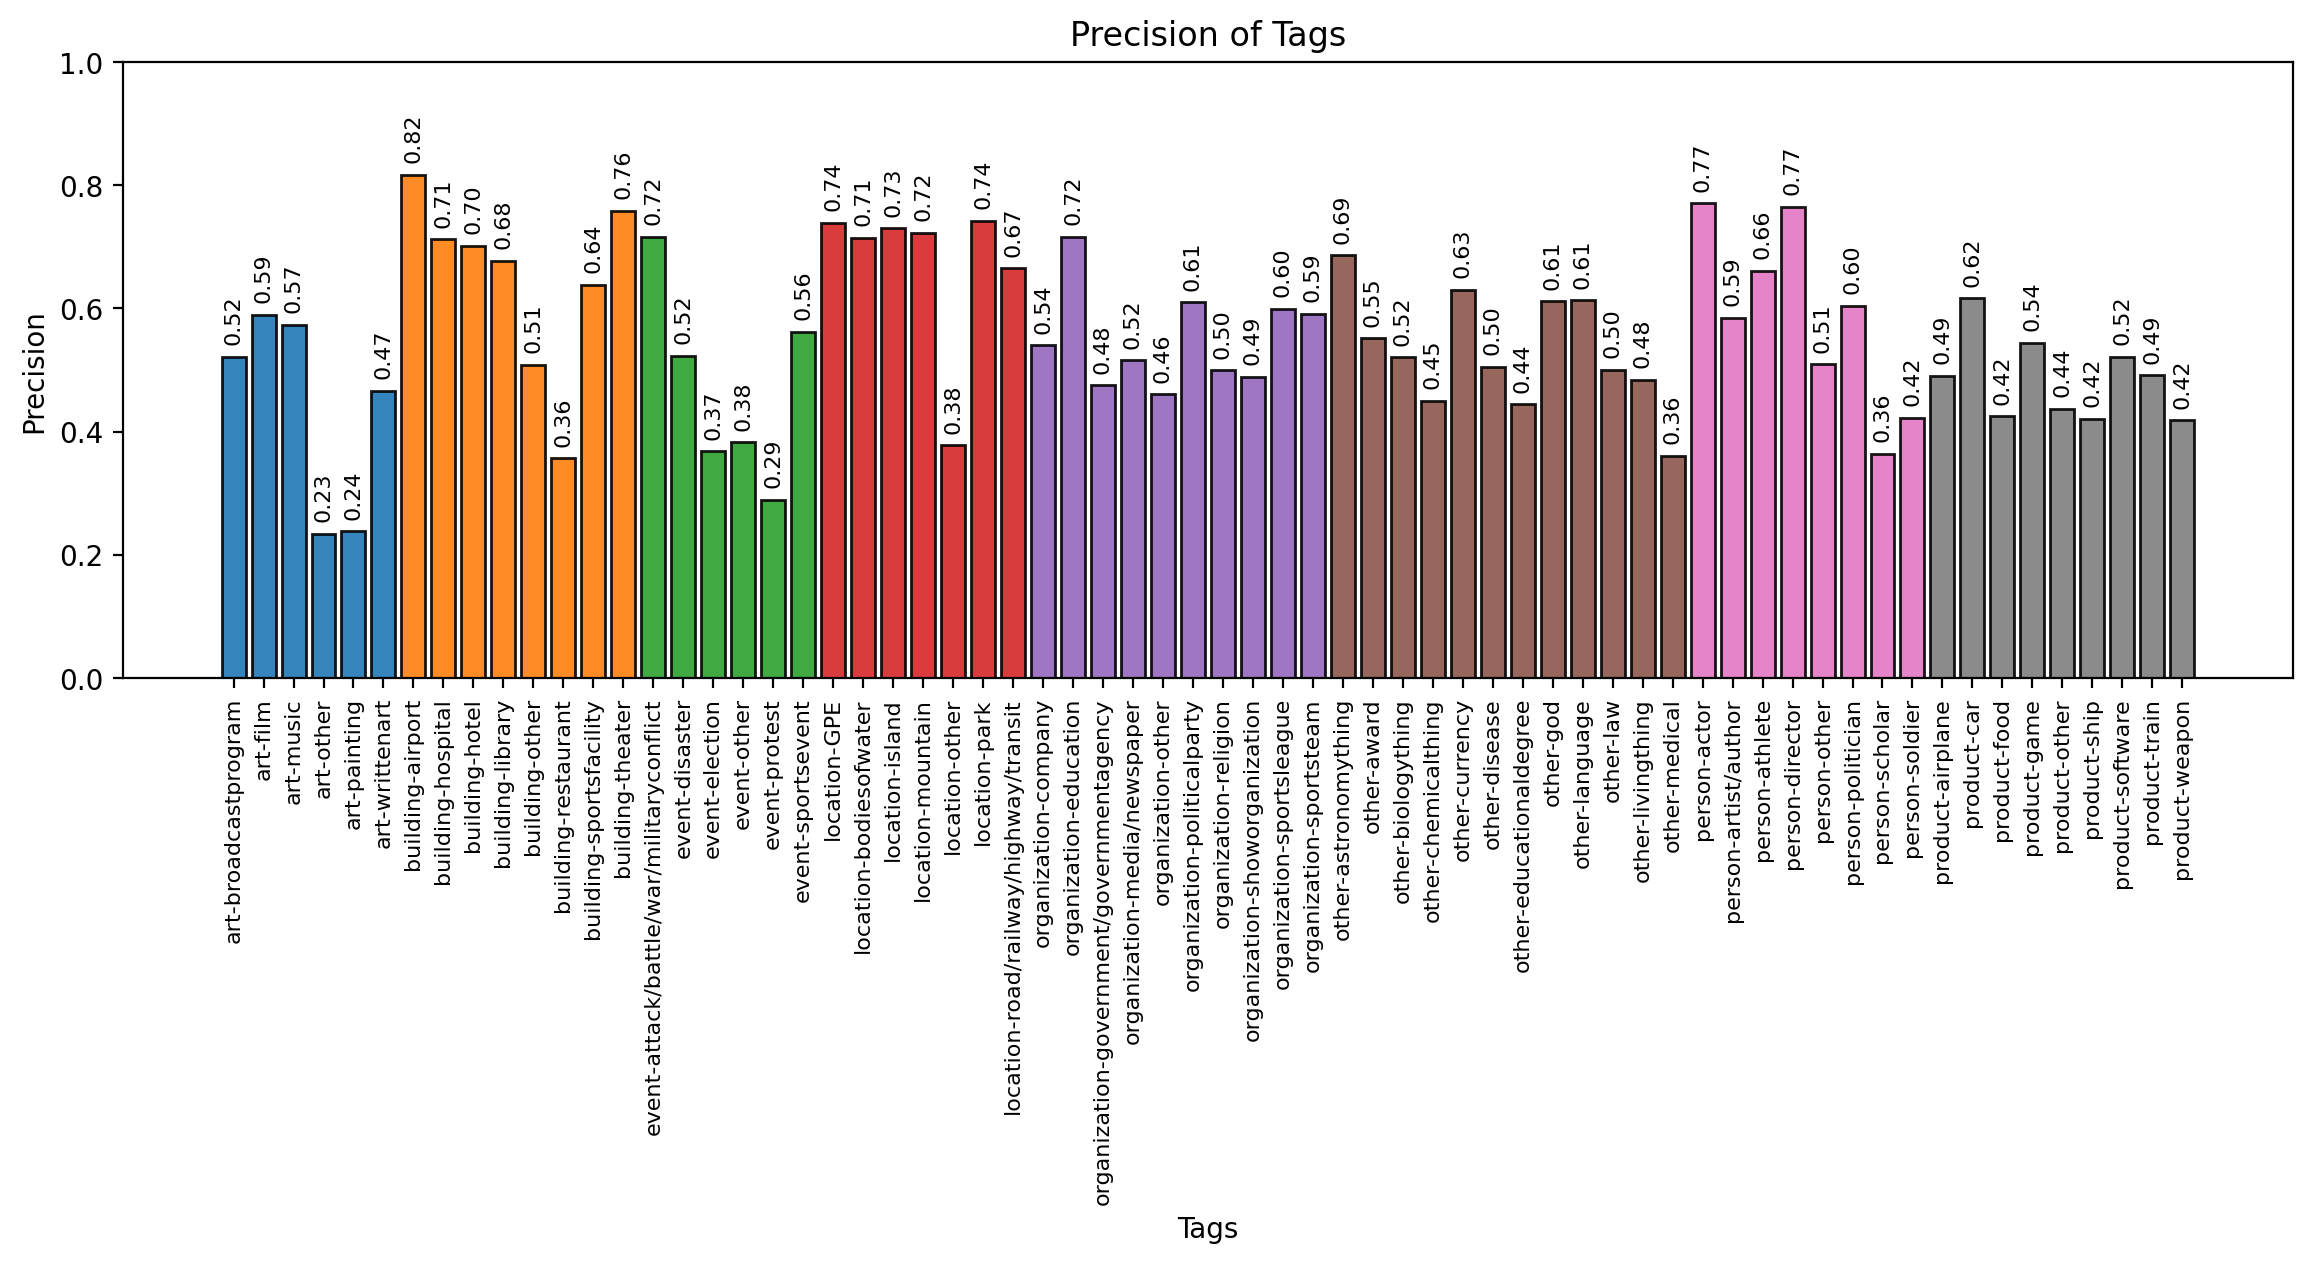

In [13]:
plot_classification_report(
    tag_names=list(TAG2IDX.keys())[2:],
    tag_scores=precision_score(y_true=batch_trues, y_pred=batch_preds, average=None)
)

# Demo

In [14]:
def predict_ner_for_sentence(sentence: str, token2idx: Dict[str, int] = TKN2IDX) -> List[str]:

    input_tokens = [token2idx[token] if token in token2idx else token2idx['UKN'] for token in sentence.split(' ')]
    input_tokens = padding(input_tokens, max_len=config.SEQ_LEN)
    input_tokens = torch.tensor(input_tokens)
    mask = (input_tokens > 0).bool()

    emission_scores = model(input_tokens.unsqueeze(0))
    preds = torch.tensor(model.decode(emission_scores)).squeeze()
    preds = [IDX2TAG[idx] for idx in preds[mask].tolist()]
    preds = io2bio(preds)

    return preds

In [89]:
# let's generate some seentencess using chatGPT
sentence = "The Mona Lisa is located in Paris and was painted by Leonardo da Vinci."
sentence = "In the Louvre museum, visitors admired the exquisite paintings of Vincent van Gogh while discussing the impact of his work on modern art."
sentence = "During a protest organized by Greta Thunberg, environmental activists gathered in front of the United Nations headquarters to demand urgent action on climate change."
sentence = "At the Nobel Prize award ceremony, the renowned physicist Stephen Hawking received recognition for his groundbreaking contributions to theoretical physics, and the event was attended by leaders from the European Organization for Nuclear Research (CERN) and influential figures from the global scientific community."

In [90]:
# list(zip(sentence.split(' '), predict_ner_for_sentence(sentence=sentence)))

In [91]:
highlighted_text = highlight_entities(
    tokens=sentence.split(' '), 
    ner_tags=predict_ner_for_sentence(sentence=sentence), 
    font_size=20
)
HTML(highlighted_text)

In [92]:
# version 45
# !tensorboard --logdir=artefacts/fine_grained/runs